# Perceptrón multicapa

En este notebook estudiaremos cómo usar una red neuronal de tipo MLP para modelar un problema de regresión (trataremos de predecir un valor numérico en lugar de una clase). En particular, trataremos de predecir el precio de casas en Boston a partir de sus características.

In [1]:
import numpy as np

# Fijar generador de números aleatorios para obtener siempre los mismos resultados
np.random.seed(123)  

In [2]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

df = pd.DataFrame(data= boston['data'], columns=boston['feature_names'])
df['target']=boston['target']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Re-escalado de los datos

Como el conjunto de datos contiene variables en distintas escalas, vamos a normalizar cada variable. En este caso, al tratarse de un problema de regresión, también debemos normalizar la variable 'target' que queremos predecir.

In [3]:
from sklearn.preprocessing import StandardScaler

# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(boston.data)
boston['data_scaled'] = scaler_x.transform(boston.data)

# Y también transformamos la variable de salida
scaler_y = StandardScaler()
scaler_y.fit(boston.target.reshape(-1, 1)) # Como es una sola variable es necesario ponerlo en modo columna
boston['target_scaled'] = scaler_y.transform(boston.target.reshape(-1, 1))

## Entrenamiento del MLP

/Users/antonio/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


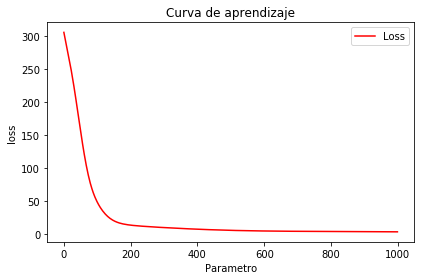

0.9301609914341417
0.8101601961254332


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Partimos el conjunto de datos en un 20% para test
X_train, X_test, y_train, y_test = train_test_split(boston.data_scaled, boston.target, 
                                                    test_size=0.3, random_state=0)

# Creamos un perceptrón multicapa
# optimiza el error cuadrático medio
# max_iter debe ser suficientemente alto para que la red se entrene
max_iter = 1000
mlp = MLPRegressor(hidden_layer_sizes=(100, ),  # sólo 1 capa oculta de 100 neuronas
                   activation='relu',           # función de activación para las capas ocultas
                   solver='adam',               # algoritmo para descenso de gradiente
                   alpha=0.001,                 # mide cuánto cambiamos los parámetros en cada actualización
                   batch_size='auto',           # por defecto 200
                   max_iter=max_iter,           # número de pasadas por los datos de entrada 
                   verbose=False)               # mostrar loss después de cada pasada
mlp.fit(X_train, y_train)

# Pintar la evolución de la función de loss
plt.plot(range(max_iter), mlp.loss_curve_, color="r",  label="Loss")
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  

# Calculamos el coeficiente R^2 del modelo para entrenamiento y test (mejor valor es 1)
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.score
print(mlp.score(X_train, y_train))
print(mlp.score(X_test, y_test))

## Buscar el valor óptimo de un parámetro usando validación cruzada

En este ejemplo vamos a probar distintos valores de la tasa de aprendizaje.

In [10]:
from sklearn.model_selection import cross_val_score

alphas = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
cv_scores_mean=[]
cv_scores_std=[]

for alpha in alphas:
    mlp = MLPRegressor(hidden_layer_sizes=(100, ), 
                       activation='relu', 
                       solver='adam', 
                       alpha=alpha, 
                       batch_size='auto',
                       max_iter=1000,
                       verbose=False)
    
    # El error es neg_mean_squared_error el MSE en negativo!! Más pequeño peor.
    scores = cross_val_score(mlp, boston['data_scaled'], boston['target_scaled'].ravel(), 
                             cv=5, scoring='neg_mean_squared_error')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

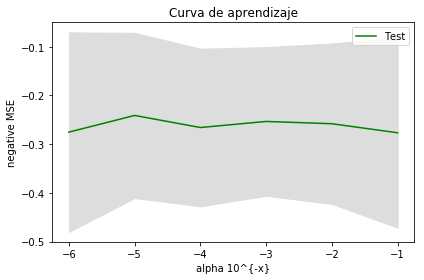

In [11]:
# Dibujamos la línea de la exactitud media en las partes de test
# Como el 
plt.plot(np.log10(alphas), cv_scores_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
lower_limit=np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit=np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(alphas), lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("alpha 10^{-x}"), plt.ylabel("negative MSE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Análisis del error

Vamos a analizar el error que comete el perceptrón con los datos originales y el valor del parámetro de regularización elegido.

NOTA: Este análisis que vamos a calcular no son obtenidas por un único perceptrón, sino por una agregación de los k perceptrones estimados en el k-fold.

In [14]:
from sklearn.model_selection import cross_val_predict

mlp = MLPRegressor(hidden_layer_sizes=(100, ), 
                   activation='relu', 
                   solver='adam', 
                   alpha=0.001, 
                   batch_size='auto',
                   max_iter=1000)
mlp.fit(X_train, y_train)

# Predecimos los precios para el conjunto de prueba
predicts_scaled = cross_val_predict(mlp, boston['data_scaled'], boston['target_scaled'].ravel(), cv=5)

# Escalamos los precios a la escala original
predicts = scaler_y.inverse_transform(predicts_scaled)

/Users/antonio/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'Distribución del error en valor absoluto')

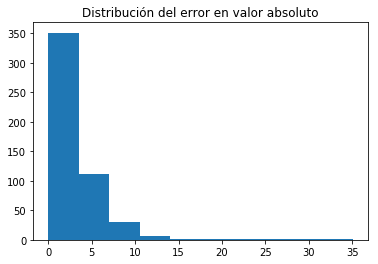

In [15]:
plt.hist(np.abs(boston.target - predicts))
plt.title('Distribución del error en valor absoluto')

La distribución del error muestra algunos valores demasiado elevados que no son deseables

Text(0.5, 1.0, 'Y Vs Y_pred')

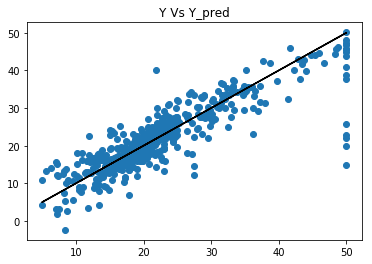

In [16]:
plt.scatter(boston.target, predicts) 
# Pintamos la referencia de la predicción perfecta
plt.plot(boston.target, boston.target, color='k') 

plt.title('Y Vs Y_pred')

Al pintar el gráfico vemos que la mayor desviación se produce para los valores de Y=50.

Esto seguramente quiere decir que se pueda mejorar la estimación y que hay que hacer algo con los valores superiores del rango.